In [1]:
from __future__ import division
from itertools import chain, combinations
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
import numpy as np
from scipy import signal
import heapq
import warnings
from matplotlib.pyplot import specgram
import time
import seaborn
from scipy.spatial.distance import cdist, pdist
%matplotlib notebook

We have imported all the libraries that we would need.
Now, let's save the data in the corresponding variables:

In [2]:
df = pd.read_excel("data.xls") #read the data
df.head() 

df.iloc[:,[1,2]] = 0 #we don't need 1,2 columns (we start counting with 0)
data = df.values

Now that we have our data downloaded, let's define some technical variables that we would need later on:

In [3]:
sr = 7 #sampling rate
#technical constants
temp = -1
count = -1
glob_count = 0
sizes_count = 0
cut_num = 8 #drop time series of the length less or equal to this quantity
from_col = 10 #we consider as features such parameters: Area,Thickness,Compactness,Intensity_variation,Length_across_beam Perimeter,Orientation
num_param = 17 - from_col #number of features
num_of_cuts = 0 #count the number of cut
sizes = data[-1,0] 
sizes_array = np.zeros((int(sizes),1)) #array to count the number of time series
new_samples_list = [] #list of the time series that are selected
#lists to count the number of holes in the time series
holes_list = []
_holes_list = []

Here we write the function that is going to use K-Means clustering with Elbow algorithm to estimate the optimal number of clusters:

In [4]:
#k-elbow method with K-means clustering algorithm
def elbow(XX, n):
	kMeansVar = [KMeans(n_clusters=k).fit(XX) for k in range(1, n)]
	centroids = [X.cluster_centers_ for X in kMeansVar]
	k_euclid = [cdist(XX, cent) for cent in centroids]
	dist = [np.min(ke, axis=1) for ke in k_euclid]
	wcss = [sum(d**2) for d in dist]
	tss = sum(pdist(XX)**2)/XX.shape[0]
	bss = (tss-wcss)/tss
	plt.plot(bss)
	plt.title('Elbow method')
	plt.xlabel('Number of clusters')
	plt.ylabel('Varaince explained')
	plt.show()
	kmeans = KMeans(n_clusters=2).fit(XX)
	labels = kmeans.labels_
	return labels  

In [8]:
data[glob_count-count:glob_count+1*(glob_count == data[:,0].size-1),3]

array([], dtype=float64)

After defining all the constants and function we need, we can proceed to the data pre-processing:

In [5]:
import time
for i in data[:,0]:
    if (i != temp) or (glob_count == data[:,0].size-1):
        temp = i
        if (count != -1) or (glob_count == data[:,0].size-1):
            X_batch = data[glob_count-count:glob_count+1*(glob_count == data[:,0].size-1),3]
            Y_batch = data[glob_count-count:glob_count+1*(glob_count == data[:,0].size-1),from_col:]
            #count the holes
            X_temp = X_batch-X_batch[0]
            holes_list.append([])
            for nn,ii in enumerate(X_temp):
                try:
                    if (map(int,list(X_temp))[nn+1]-map(int,list(X_temp))[nn])!=1:
                        holes_list[int(i)-2+1*(glob_count == data[:,0].size-1)]\
                        .append(map(int,list(X_temp))[nn+1]-map(int,list(X_temp))[nn]-1)
                        _holes_list.append(map(int,list(X_temp))[nn+1]-map(int,list(X_temp))[nn]-1)

                except Exception as e:
                    pass
            #add the time series wiht selected paramters to the new_samples_list
            for j in range(from_col,from_col+Y_batch[0,:].size):
                Y_batch_temp = data[glob_count-count:glob_count+1*(glob_count == data[:,0].size-1),j] #get the selected parameters
                _X_temp = X_batch-X_batch[0] #rescale the index of the time order of the time series
                X_temp = np.arange(_X_temp[-1]+1) #create new time intervals for the interpolated time series
                Y_temp = np.interp(X_temp,_X_temp,Y_batch_temp) #interpolate the time series
                if j == 14:
                    _max = max(Y_batch_temp)
                    sizes_array[int(i)-2+1*(glob_count == data[:,0].size-1)] = _max
                #sizes_array[int(i)-2+1*(glob_count == data[:,0].size-1)] = len(X_temp) #get the size of the new interpolated time series
                
                
                if len(X_temp)<=cut_num:
                    #drop the times series if their interpolated lentgth <= cut_num
                    if (j-from_col)==0:
                        num_of_cuts+=1
                else:
                    #add other time series to the new_samples_list
                    if (j-from_col)==0:
                        new_samples_list.append([])
                        new_samples_list[int(i)-2 + 1*(glob_count == data[:,0].size-1)-num_of_cuts].append([])
                        new_samples_list[int(i)-2 + 1*(glob_count == data[:,0].size-1)-num_of_cuts][0] \
                        = int(i)-2 + 1*(glob_count == data[:,0].size-1)	

                    new_samples_list[int(i)-2 + 1*(glob_count == data[:,0].size-1)-num_of_cuts].append([])
                    new_samples_list[int(i)-2 + 1*(glob_count == data[:,0].size-1)-num_of_cuts][j-from_col+1] = Y_temp
 
        count = 0
    count+=1
    glob_count+=1


Now let's show some statistics of the array of the lengthes of the time series that correspond to our fishes:

In [6]:
print 'Statistics of the array of the length of time series: \nstd = ', np.std(sizes_array), 'mean = ', np.mean(sizes_array), 'min = ', np.min(sizes_array),'max = ', np.max(sizes_array)


Statistics of the array of the length of time series: 
std =  36.3902587375 mean =  64.9281132068 min =  18.875137 max =  445.839926


Furthermore, we could plot the histogram of the sizes:

<IPython.core.display.Javascript object>


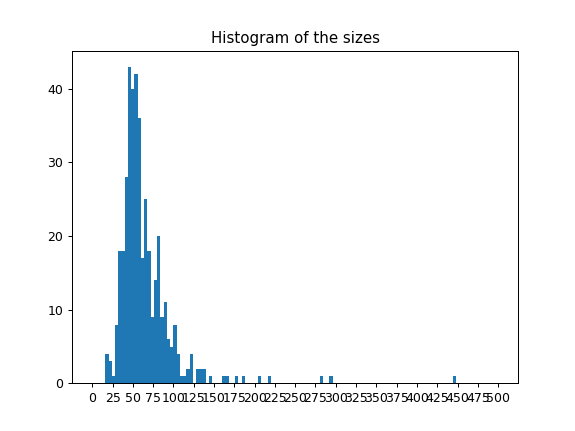

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  


In [7]:
import seaborn
step_size = 4
ax = plt.subplot(1,1,1)
ax.set_xticks(map(int,np.linspace(0,500,21)))
ax.set_xticklabels(map(int,np.linspace(0,500,21)))
plt.hist(sizes_array,map(int,np.linspace(0,500,500/step_size+1)))
plt.title('Histogram of the sizes')
plt.show()

In order to make things more clear we also plot the histogram of the gaps in original time series (which are then linearly interpolated):

<IPython.core.display.Javascript object>


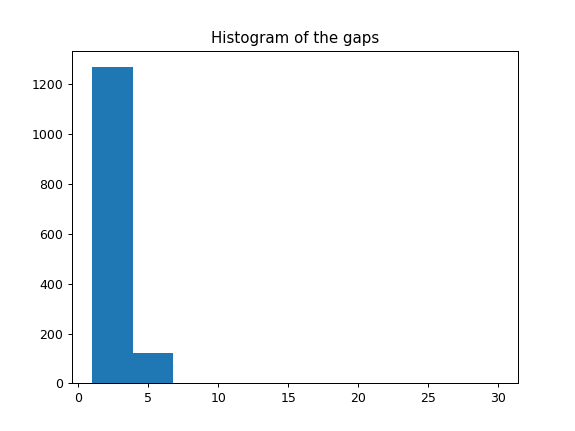

In [8]:
plt.hist(_holes_list)
plt.title('Histogram of the gaps')
plt.show()

One could also mention the biggest 20 gaps:

In [10]:
print 'The sizes of the biggest gaps in time series:', heapq.nlargest(20,_holes_list)

The sizes of the biggest gaps in time series: [30, 18, 13, 9, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


Let's now proceed to the transforamtion of our features which are presented by the high-dimensional time series to the vector of 6 frequencies as defined in the paper:

In [9]:
import time
features = np.zeros((len(new_samples_list),6))  #new features vector for the fishes - corresponds to the 6 frequencies

for q in range(len(new_samples_list)):
    fish_n=q
    Cxy = [] #list of the coherence functions for all possible pairs of the parameters 
             #(Area,Thickness,Compactness,Intensity_variation,Length_across_beam Perimeter,Orientation) for each fish
    for enum,i in enumerate([z for z in combinations(range(len(new_samples_list[fish_n])-1),2)]):
        Cxy.append([])
        f, Cxy[enum] = signal.coherence(new_samples_list[fish_n][1+i[0]], new_samples_list[fish_n][1+i[1]],sr,nperseg\
                                        =len(new_samples_list[fish_n][1+i[0]])/1.85) #calculation of the coherence 
                                                                                     #function with the window size 
                                                                                     #of length (1/1.85) of the original
                                                                                     #time series length 
  
    #_sum_small = heapq.nsmallest(2,[sum(k[~np.isnan(k)]) for k in Cxy]) #selection of two pairs of parameters with the least energy 
                                                                   #of the coherence function
    
    #_sum_small_ind = [i for i,x in enumerate([sum(k[~np.isnan(k)]) for k in Cxy]) if x in _sum_small]
    
#     biggest_w1 = heapq.nlargest(3,Cxy[17][~np.isnan(Cxy[17])]) #selection of the three frequencies with the highest energy 
                                                          #in the first pair
#     biggest_w2 = heapq.nlargest(3,Cxy[10][~np.isnan(Cxy[10])]) #selection of the three frequencies with the highest energy 
                                                          #in the second pair
    _sum_small = heapq.nsmallest(2,[sum(k) for k in Cxy if not np.isnan(k).any()])
    _sum_small_ind = [i for i,x in enumerate([sum(k[~np.isnan(k)]) for k in Cxy if not np.isnan(k).any()]) if x in _sum_small]
    biggest_w1 = heapq.nlargest(3,Cxy[_sum_small_ind[0]][~np.isnan(Cxy[_sum_small_ind[0]])])
    biggest_w2 = heapq.nlargest(3,Cxy[_sum_small_ind[1]][~np.isnan(Cxy[_sum_small_ind[1]])])
    
    w = biggest_w1+biggest_w2 #list of the 6 selected frequencies
    features[q] = w

/usr/local/lib/python2.7/dist-packages/scipy/signal/spectral.py:1233: RuntimeWarning: invalid value encountered in true_divide
  Cxy = np.abs(Pxy)**2 / Pxx / Pyy


In [11]:
import time
from collections import Counter
features = np.zeros((len(new_samples_list),6))  #new features vector for the fishes - corresponds to the 6 frequencies
a = []
for q in range(len(new_samples_list)):
    fish_n=q
    Cxy = [] #list of the coherence functions for all possible pairs of the parameters 
             #(Area,Thickness,Compactness,Intensity_variation,Length_across_beam Perimeter,Orientation) for each fish
    for enum,i in enumerate([z for z in combinations(range(len(new_samples_list[fish_n])-1),2)]):
        Cxy.append([])
        f, Cxy[enum] = signal.coherence(new_samples_list[fish_n][1+i[0]], new_samples_list[fish_n][1+i[1]],sr,nperseg\
                                        =len(new_samples_list[fish_n][1+i[0]])/1.85) #calculation of the coherence 
                                                                                     #function with the window size 
                                                                                     #of length (1/1.85) of the original
                                                                                     #time series length 
  
    _sum_small = heapq.nsmallest(2,[sum(k[~np.isnan(k)]) for k in Cxy]) #selection of two pairs of parameters with the least energy 
    _sum_small_ind = [i for i,x in enumerate([sum(k[~np.isnan(k)]) for k in Cxy]) if x in _sum_small]
    
    a.extend(_sum_small_ind)

count = Counter(a)
print count.most_common()

[(17, 73), (10, 68), (14, 62), (11, 61), (19, 58), (5, 56), (8, 54), (7, 51), (15, 51), (20, 49), (6, 45), (1, 41), (2, 33), (16, 32), (9, 30), (0, 18), (3, 12), (13, 5), (12, 2), (18, 2), (4, 1)]


As this step is done, we can use our new features (6 features for each fish) and apply the function with the K-Means clustering and Elbow method as it was defined before. Here we get the corresponding labels: 
(the Elbow method gives us the variance explained by the number of clusters. Looking at the graph we can observe that the variance is best explained by two clusters and furher clusters increase this quantity insignificantly)

<IPython.core.display.Javascript object>


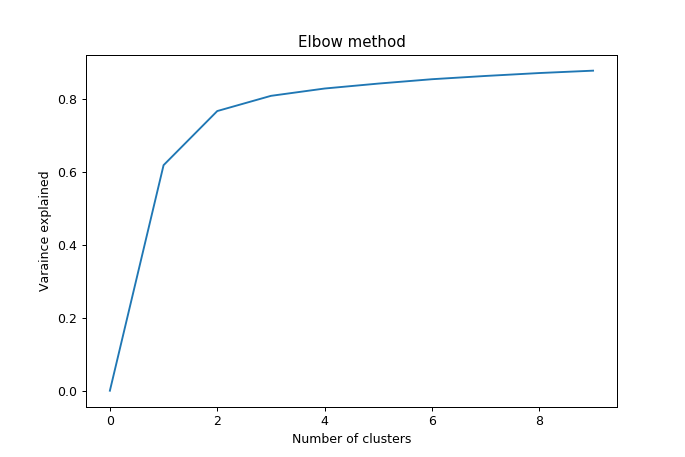

In [10]:
labels = elbow(features,11) #Cluster the fishes with new features and plot the variance explained

Using the labels that we have extracted, we can identify the fishes in both groups and count the number in each of them:

In [11]:
numbers_of_fishes = [] #let's get the indices of the fishes that are considered (the fishes with the time intervals of the length <=8
                       # are omitted  

for i in new_samples_list:
	numbers_of_fishes.append(i[0])
_temp = np.array(labels)*(1+np.array(numbers_of_fishes))
group_1 = _temp[_temp!=0]
_temp = (np.array(labels)==0)*(1+np.array(numbers_of_fishes))
group_2 = _temp[_temp!=0]
print "Group N1: ",group_1
print "Group N2: ",group_2
print "Len Group N1: ", len(group_1)
print "Len Group N2: ", len(group_2)

Group N1:  [  1   2   4  10  11  19  26  30  32  37  48  51  53  63  67  70  75  76
  78  84  86  88  89  91  93  94  96  99 100 101 102 103 105 112 118 119
 123 136 142 144 145 146 147 153 157 161 165 166 170 183 184 191 195 199
 202 204 209 217 219 226 228 230 231 232 237 238 239 244 248 259 266 269
 270 272 274 278 280 281 282 283 284 288 289 292 293 298 299 301 302 304
 305 310 311 315 317 318 319 320 322 324 325 326 329 330 338 341 342 343
 345 347 355 359 371 375 384 385 386 387 388 389 395 396 397 399 400 402
 405 406 408]
Group N2:  [  3   5   6   7   8  12  13  14  15  16  17  18  20  21  22  23  24  25
  27  28  29  31  33  34  35  36  38  39  40  41  42  43  44  45  46  47
  49  50  52  54  55  56  57  58  59  60  61  62  64  65  66  68  69  71
  72  73  74  77  79  80  81  82  83  85  87  90  92  95  98 104 106 107
 109 110 111 113 114 115 116 117 120 124 125 126 127 128 129 130 131 132
 133 134 135 137 138 139 140 141 143 148 149 150 151 152 154 155 156 158
 159 160 162 16

As our work is almost done, let's print the histogram of the sizes of the time series in the both groups out:

<IPython.core.display.Javascript object>


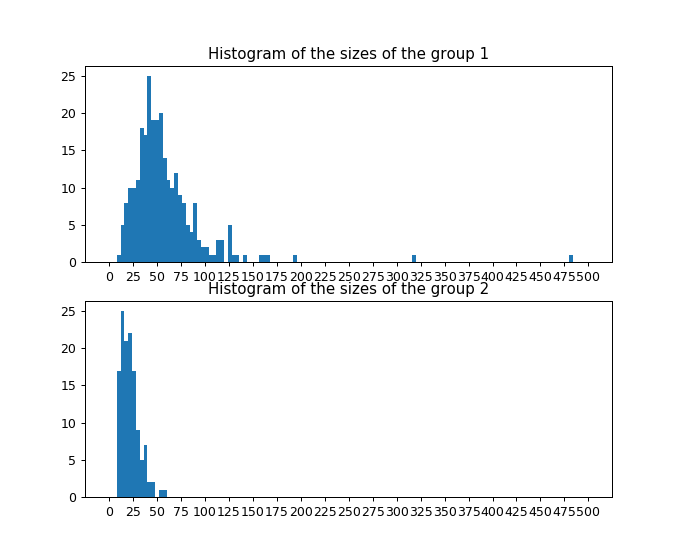

In [12]:
sizes_group_1 = [len(k[1]) for k in new_samples_list if (k[0]+1) in group_1]
sizes_group_2 = [len(k[1]) for k in new_samples_list if (k[0]+1) in group_2]


if len(sizes_group_1)<len(sizes_group_2):
    temp = sizes_group_1
    sizes_group_1 = sizes_group_2
    sizes_group_2 = temp

ax = plt.subplot(2,1,1)
ax.set_xticks(map(int,np.linspace(0,500,21)))
ax.set_xticklabels(map(int,np.linspace(0,500,21)))
h = plt.hist(sizes_group_1,map(int,np.linspace(0,500,500//step_size+1)))
plt.title('Histogram of the sizes of the group 1')
ax = plt.subplot(2,1,2)	
ax.set_xticks(map(int,np.linspace(0,500,21)))
ax.set_xticklabels(map(int,np.linspace(0,500,21)))
plt.hist(sizes_group_2,map(int,np.linspace(0,500,500//step_size+1)))
plt.title('Histogram of the sizes of the group 2')
plt.show()

In order to be sure that the the found clusters correspond to the different groups of fishes we will:


1) Implement Kolmogorov-Smirnov test and check, whether the null hypothesis is rejected at the given level(e.g alpha = 0.001). It will be rejected, when Kolmogorov-Smirnov statistics will be greater than the corresponding quantity(it will be described in the paper).

2) Fit different distributions to the lengths of the groups found and visually find that these distributions are unlike.
Note: only the first part is necessary to statistically reject or accept the hypothesis tested. The second part will give us more intuitive and visuall representation of the comparison.

<IPython.core.display.Javascript object>


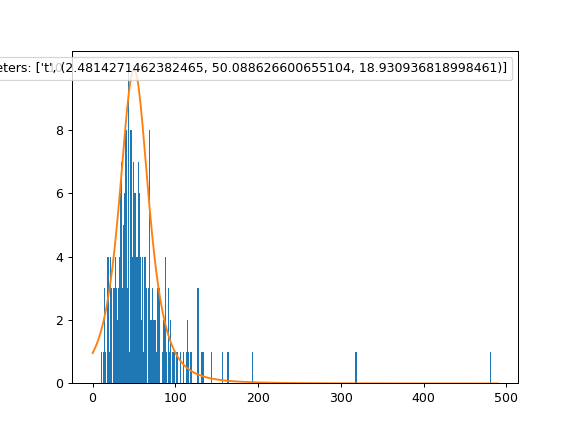

______Part_1____________

Kolmogorov-Smirnov statistic for our 2 distributions =  0.919413919414 
If it is greater than the following value (more details in the paper), then the null hypothesis is rejected at level alpha:  0.208339424053
______Part_2____________

Kolmogorov-Smirnov Statistic =  0.241758241758 ['t', (2.4814271462382465, 50.088626600655104, 18.930936818998461)]


<IPython.core.display.Javascript object>


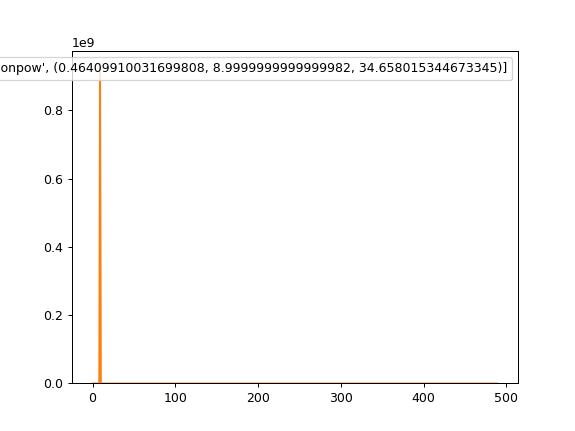

Kolmogorov-Smirnov Statistic =  0.124031007752 ['exponpow', (0.46409910031699808, 8.9999999999999982, 34.658015344673345)]


In [13]:
from __future__ import division
import scipy.stats
import warnings
warnings.filterwarnings("ignore")

alpha = 0.001
critical_value = lambda x: (x==0.10)*1.22+(x==0.05)*1.36+(x==0.025)*1.48+(x==0.01)*1.63+(x==0.005)*1.73+(x==0.001)*1.95
h1 = plt.hist(sizes_group_1, bins=len(sizes_group_1),cumulative=True)
plt.clf()  
h2 = plt.hist(sizes_group_2, bins=len(sizes_group_2),cumulative=True)
plt.clf()  
print '______Part_1____________\n'
print 'Kolmogorov-Smirnov statistic for our 2 distributions = ', scipy.stats.ks_2samp(h1[0],h2[0])[0], \
      '\nIf it is greater than the following value (more details in the paper), then the null hypothesis is',\
      'rejected at level alpha: ',\
      critical_value(alpha)*np.sqrt((len(sizes_group_1)+len(sizes_group_2))/(len(sizes_group_1)*len(sizes_group_2)))
print '______Part_2____________\n'
def fit_the_distr(sizes_group,mult=1):
    size = len(sizes_group)
    x = scipy.arange(size)
    y = sizes_group

    #list of all possible distributions
    dist_names = ['gamma','beta','rayleigh', 'norm', 'pareto','alpha', 'anglit','betaprime', 'bradford', 'burr', 'cauchy', 'chi',\
                  'chi2', 'cosine', 'dgamma','dweibull', 'erlang', 'expon', 'exponweib', 'exponpow', 'f',\
                  'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic',\
                  'genpareto', 'genexpon', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', \
                  'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant',\
                  'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic',\
                  'loggamma', 'loglaplace',  'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', \
                  'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist',\
                  'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon',\
                  'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min', 'weibull_max']
    #we will use the kolmogorov-smirnov test to select the best fit
    kolmogorov_smirnow = np.zeros(len(dist_names))
    h = plt.hist(y, bins=size,cumulative=True)
    plt.clf()                      

    params = []
    for i,dist_name in enumerate(dist_names):
        dist = getattr(scipy.stats, dist_name)
        param = dist.fit(y)
        pdf_fitted = dist.cdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size #here we get the cdf of the reference distribution
        params.append([])
        params[i].append([])
        params[i].append([])
        params[i][0] = dist_name
        params[i][1] = param 
        _hist = h[0] #empirical distribution function
        _fit = np.array(pdf_fitted) #distribution fitted
        #one could plot the graphs of the cdf both of the distribution fitted and the  one
        #plt.bar(np.arange(size),h[0])
        #plt.plot(pdf_fitted)
        #plt.legend(loc='upper left')
        #plt.show()
        kolmogorov_smirnow[i] = scipy.stats.ks_2samp(_fit,_hist)[0] #the kolmogorov-smirnov statistic

    b = kolmogorov_smirnow
    dist_n = params[int(np.where(b == np.min(b[~np.isnan(b)]))[0])][0] #get the name of the optimal distribution 
                                                                       #(with the smallest k-s statistic)
    #print the name of the distribution that fits the data the best and its parameters 
    _param =  params[int(np.where(b == np.min(b[~np.isnan(b)]))[0])]
    print 'Kolmogorov-Smirnov Statistic = ', np.min(b[~np.isnan(b)]), _param
    #now let's plot the distribution and compare it with the sample data
    dist = getattr(scipy.stats, dist_n)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(np.arange(490), *param[:-2], loc=param[-2], scale=param[-1]) * size * mult
    h = plt.hist(y, bins=range(491))

    plt.bar(np.arange(490),h[0])
    plt.plot(pdf_fitted, label=dist_n+"; Parameters: "+str(_param))
    plt.legend(loc='upper right')
    
plt.figure(1)
fit_the_distr(sizes_group_1,1.9) #here we use the factor 1.9 to scale the first fitted distribution, 
                                 #in order to display it accordingly to the histogram 
                                 #as the data (as it can be seen from the histogram
plt.figure(2)                    #contains a lot of gaps)
fit_the_distr(sizes_group_2)
plt.show()


1) Kolmogorov-Smirnov test shows us that the distributions differ drastically and the null hypothesis is rejected even at level 0.001 ((0.9194)>(0.210), here 0.9194is the K-S-statistic and 0.210 is the corresponding value).

2) One can also find the distributions that fit out sample data the best. The difference is seen visually.